In [4]:
#importing package

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

from math import exp, log, sqrt
from scipy.stats import norm

In [68]:
# defining european option within the Black & Scholes framework


class EquityDerivativesBS:
    def __init__(self, S, T, K, sigma, r, div=0, t=0):
        self.S = S  # Spot price
        self.T = T  # Maturity
        self.K = K  # Strike price
        self.sigma = sigma  # Implied volatility
        self.r = r
        self.div = div  # dividend yield
        self.t = t  # Current time step t

    @property
    def parameters(self):
        return {
            'S': self.S,
            'T': self.T,
            'K': self.K,
            'sigma': self.sigma,
            'r': self.r,
            'div': self.div,
            't': self.t
        }

    def d1(self):
        return ((log(self.S / self.K) +
                 (self.r - self.div + ((self.sigma**2) / 2) *
                  (self.T - self.t))) / (self.sigma * sqrt(self.T - self.t)))

    def d2(self):
        return self.d1() - self.sigma * sqrt(self.T - self.t)

    def call_price(self):
        return self.S * exp(-self.div * (self.T - self.t)) * norm.cdf(
            self.d1()) - self.K * exp(-self.r *
                                 (self.T - self.t)) * norm.cdf(self.d2())

    def put_price(self):
        return self.K * exp(
            -self.r * (self.T - self.t)) * norm.cdf(-self.d2()) - self.S * exp(
                -self.div * (self.T - self.t)) * norm.cdf(-self.d1())

    def price(self, type_='C'):
        if type_ == "Call":
            return self.call_price()
        elif type_ == "Put":
            return self.put_price()

    # Def option greeks

    def delta_bs(self, type_='C'):
        if type_ == "Call":
            return norm.cdf(self.d1())
        elif type_ == "Put":
            return norm.cdf(self.d1()) - 1

    def gamma_bs(self):
        return norm.pdf(self.d1()) / (self.S * self.sigma * sqrt(self.T))

    def vega_bs(self):
        return self.S * sqrt(self.T) * norm.pdf(self.d1())

    def theta_bs(self, type_='C'):

        cash_or_nothing_call = self.K * exp(-self.r * self.T) * norlm.cdf(
            self.d2())
        cash_or_nothing_put = self.K * exp(
            -self.r * self.T) * norlm.cdf(-self.d2())

        if type_ == "Call":
            return -0.5 * self.gamma_bs() * (self.S**2) * (
                self.sigma**2) - self.r * cash_or_nothing_call
        elif type_ == "Put":
            return -0.5 * self.gamma_bs() * (self.S**2) * (
                self.sigma**2) - self.r * cash_or_nothing_put

    def rho_bs(self, type_='C'):
        cash_or_nothing_call = self.K * exp(-self.r * self.T) * norlm.cdf(
            self.d2())
        cash_or_nothing_put = self.K * exp(
            -self.r * self.T) * norlm.cdf(-self.d2())
        if type_ == "Call":
            return self.K * self.T.cash_or_nothing_call
        elif type_ == "Put":
            return -self.K * self.T.cash_or_nothing_put

    ## Generate paths under Blacks & Scholes diffusion framework ##

    def generate_random_paths(self, nb_paths, nb_steps):

        # Drift of the Geometric Brownian Motions #
        q = self.div
        mu = self.r
        T = self.T
        sigma = self.sigma
        S0 = self.S

        # Time step #

        dt = T / nb_steps
        rows = nb_paths

        # Simulate a matrix containing all the Bt #
        # dBt = Bt - Bs follows a law N(O , t-s) = sqrt(t-s)*N(O,1)
        dW = np.sqrt(dt) * np.random.randn(nb_paths, nb_steps)

        dS = (mu - q - 0.5 * sigma**2) * dt + sigma * dW

        dS = np.insert(dS, 0, 0, axis=1)
        S = np.cumsum(dS, axis=1)

        S = S0 * np.exp(S)

        return S

    ## pay-off:  f(ST) = 2/T ((ST - S*)/S* - log(ST/S*) ##

    def log_payoff(self, S_T, ref_spot, T):
        return 2 / T * ((S_T / ref_spot - 1) - np.log(S_T / ref_spot))

    ## Compute the call & put weights Dermeterfi et al. 1995 Method ##
    def compute_weights(self, call_strikes_list, put_strikes_list, ref_spot,
                        T):

        call_weights = []
        put_weights = []
        numbers_it = len(call_strikes_list)
        dk = call_strikes_list[1] - call_strikes_list[0]
        call_strikes_list = np.append(call_strikes_list,
                                      call_strikes_list[-1] + dk)
        put_strikes_list = np.flip(
            np.insert(put_strikes_list, 0, put_strikes_list[0] - dk))

        for i in range(numbers_it):
            # Compute the weight_i
            call_weight_i = (
                self.log_payoff(call_strikes_list[i + 1], ref_spot, T) -
                self.log_payoff(call_strikes_list[i], ref_spot, T)) / (
                    call_strikes_list[i + 1] - call_strikes_list[i])
            put_weight_i = (
                self.log_payoff(put_strikes_list[i + 1], ref_spot, T) -
                self.log_payoff(put_strikes_list[i], ref_spot, T)) / (
                    put_strikes_list[i] - put_strikes_list[i + 1])

            # Substract the sum of the previous weights
            call_weight_i -= np.sum(call_weights)
            put_weight_i -= np.sum(put_weights)

            # Add the last weight to the list of weights
            call_weights.append(call_weight_i)
            put_weights.append(put_weight_i)

        return np.array(call_weights), np.array(put_weights)

    ## Compute the Realized variance for a given random paths ##

    def realized_volatility(self, simulated_paths):
        nb_paths, nb_steps = simulated_paths.shape()
        realized_volatilities = []
        step = 0
        asset = 0
        squared_return = []
        for asset in range(nb_paths):
            while i < (nb_steps - 1):
                squared_return.append(
                    np.log((simulated_paths.item(j, i + 1) /
                            simulated_paths.item(j, i))**2))
                step += 1
            step = 0
            realized_vol = np.mean(squared_return)
            realized_volatilities.append(realized_vol)
            squared_return = []
        return realized_volatilities

    def variance_swap_price(self, K, nb_steps=20, nb_paths=2000):
        paths = self.generate_random_paths(nb_paths, nb_steps)
        rvs = self.realized_volatility(paths)
        payoffs = []
        for k in K:
            payoff_i = rvs - k
            payoffs.append(np.mean(payoff_i))
        return np.array(payoffs)

    def monte_carlo_realized_volatility(self, nb_paths, nb_steps, T=[1]):
        ks = []
        for t in T:
            paths = self.generate_random_paths(nb_paths, nb_steps)
            ks.append(np.mean(self.realized_volatility(paths)))
        return np.array(ks)

    def variance_strike_discrete(self,
                                 T=[1],
                                 ref_spot=None,
                                 nb_strikes=1000,
                                 strike_range=80):
        variance_strikes = []
        r = self.r
        sigma = self.sigma
        S0 = self.S 
        # If no ref spot is given then we take ATM strike i.e 100 #

        if ref_spot == None:
            ref_spot = self.K

        if strike_range > ref_spot:
            strike_range = ref_spot - 1

        # Create the array of evenly separated strikes 0 to ref_spot for put & ref_spot to
        put_strikes_list = np.linspace(ref_spot - strike_range, ref_spot,
                                       nb_strikes)
        call_strikes_list = np.linspace(ref_spot, ref_spot + strike_range,
                                        nb_strikes)

        ## Price the forward realized variance for a given maturity T ##

        for t in T:
            call_weights, put_weights = self.compute_weights(
                call_strikes_list, put_strikes_list, ref_spot, t)

            term_1 = 2 / t * (r * t - (np.exp(r * t)*(S0/ref_spot) - 1) - np.log(ref_spot/S0))
            put_prices = [
                EquityDerivativesBS(S0, t, put_strikes, sigma, r).put_price()
                for put_strikes in put_strikes_list
            ]
            call_prices = [
                EquityDerivativesBS(S0, t, call_strikes, sigma,
                                    r).call_price()
                for call_strikes in call_strikes_list
            ]

            ## Compounded weighted sum ##
            term_2 = np.exp(r * t) * (np.sum(put_prices * put_weights) +
                                      np.sum(call_prices * call_weights))

            
            ## Adding the variance strike at time t to the list of variance strikes ##
            variance_strikes.append(term_1 + term_2)

        return np.array(variance_strikes)

In [64]:
## Distribution of Gamma ##


# return the gamma distribution for an option of a given strike K
def gamma_distribution(spot_list, K, weight=1):

    gamma_distribution_weigthed = [
        EquityDerivativesBS(S, T, K, sigma, r).gamma_bs() * (S**2)
        for S in spot_list
    ]

    return [elem * weight for elem in gamma_distribution_weigthed]


# return the gamma distribution of list of option of different strikes
def multiple_gamma_distribution(spot_list, strike_list):
    multiple_gamma_distribution_list = [
        gamma_distribution(spot_list, strikes) for strikes in strike_list
    ]
    return multiple_gamma_distribution_list


# return a list containing the value of the function accumulating the gamma value of option of different strike
# for a given spot level
def cumulative_gamma_distribution(spot_list, strike_list):
    cumulative_gamma = []
    gamma_sum = 0
    number_row = len(strike_list)
    number_column = len(spot_list)
    gamma_array = np.array(multiple_gamma_distribution(spot_list, strike_list))

    cumulative_gamma = [
        sum(gamma_for_spot) for gamma_for_spot in zip(*gamma_array)
    ]
    return cumulative_gamma


def multiple_gamma_distribution_weight_K(spot_list, strike_list):
    multiple_gamma_distribution_list = [
        gamma_distribution(spot_list, strikes, (1 / float(strikes / 100)))
        for strikes in strike_list
    ]
    return multiple_gamma_distribution_list


def cumulative_gamma_distribution_weight_K(spot_list, strike_list):
    cumulative_gamma = []
    gamma_sum = 0
    number_row = len(strike_list)
    number_column = len(spot_list)
    gamma_array = np.array(
        multiple_gamma_distribution_weight_K(spot_list, strike_list))

    cumulative_gamma = [
        sum(gamma_for_spot) for gamma_for_spot in zip(*gamma_array)
    ]
    return cumulative_gamma


def multiple_gamma_distribution_weight_K_squared(spot_list, strike_list):
    multiple_gamma_distribution_list = [
        gamma_distribution(spot_list, strikes, (1 / float(
            (strikes**2) / 10000))) for strikes in strike_list
    ]

    return multiple_gamma_distribution_list


def cumulative_gamma_distribution_weight_K_squared(spot_list, strike_list):
    cumulative_gamma = []
    gamma_sum = 0
    number_row = len(strike_list)
    number_column = len(spot_list)
    gamma_array = np.array(
        multiple_gamma_distribution_weight_K_squared(spot_list, strike_list))

    cumulative_gamma = [
        sum(gamma_for_spot) for gamma_for_spot in zip(*gamma_array)
    ]
    return cumulative_gamma

In [118]:
## Gamma - Theta P&L ##

## Returns the dollar gammas at each point of the simulated paths ##


def dollar_gammas_paths(prices, model):
    dollar_gammas = prices.iloc[1:, :]
    dollar_gammas = dollar_gammas.apply((lambda x: 0.5 *
                                         (x**2) * model.gamma_bs()))
    return dollar_gammas

    ## returns the squared returns at each time step ##


def realized_returns_squared(prices):
    returns_squared = (prices.pct_change()**2)
    returns_squared = returns_squared.iloc[1:, :]
    return returns_squared

def realized_volatility(prices):
    # Given a spot path returns the daily annualized realized volatility 
    realized_vol = 252*np.std(np.log(prices / prices.shift(-1)).dropna())**0.5
    #realized_vol = realized_vol.iloc[1:, :]
    return realized_vol

def realized_variance_spread(returns_squared, spread):
    variance_spread = returns_squared - spread
    return variance_spread


## European Option Path-Dependency ##


def gamma_theta_pl(model, spot_path, nb_paths, nb_steps):
    ## Parameters ##
    maturity = model.T
    sigma = model.sigma
    dt = maturity / nb_steps
    spread = (sigma**2) * dt
    ## Generate the Dataframe of spot prices processes ##
    price_paths = spot_path
    returns_squared = realized_returns_squared(price_paths)
    dollar_gammas = dollar_gammas_paths(price_paths, model)

    returns_squared = returns_squared.to_numpy()
    variance_spread = realized_variance_spread(returns_squared, spread)

    dollar_gammas = dollar_gammas.to_numpy()

    pl_t = dollar_gammas * variance_spread
    pl_t = pd.DataFrame(pl_t)

    total_pl = pl_t.cumsum()
    total_pl.head()
    return total_pl


def create_spot_paths(model, nb_paths, nb_steps):
    spot_path = pd.DataFrame(model.generate_random_paths(nb_paths, nb_steps)).T
    return spot_path

<ipython-input-56-a4ae2c62aa93>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(labels)


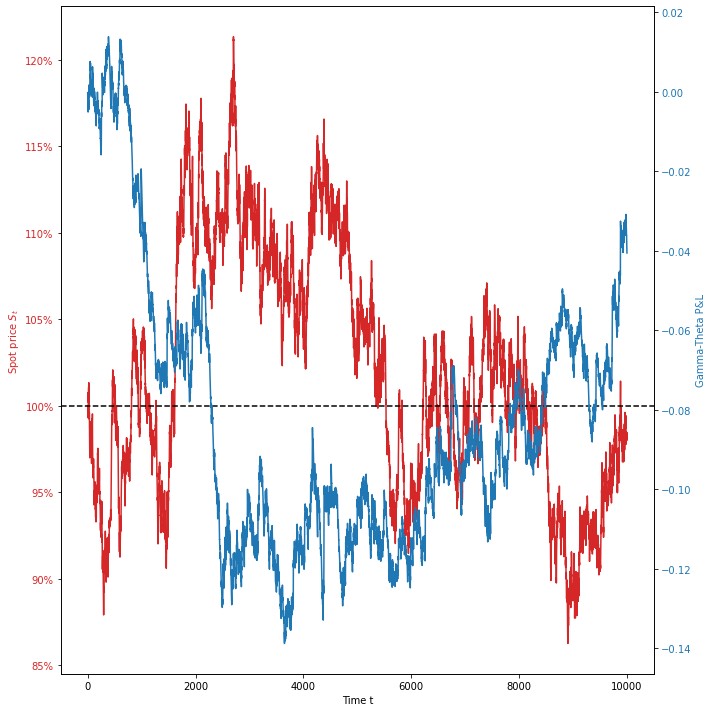

In [56]:
## Parameters ##

model = EquityDerivativesBS(100, 1, 100, 0.4, 0.04)
nb_paths = 1
nb_steps = 10000

## Creating the paths ##
spot_paths = create_spot_paths(model, nb_paths, nb_steps)
gamma_theta_p_l = gamma_theta_pl(model, spot_paths, nb_paths, nb_steps)

## Plot ##
fig, ax1 = plt.subplots(figsize=(10, 10))

color = 'tab:red'
ax1.set_xlabel('Time t')
ax1.set_ylabel('Spot price $S_t$', color=color)
ax1.plot(spot_paths, color=color)
ax1.axhline(y=model.K, color="black", linestyle="--")
ax1.tick_params(axis='y', labelcolor=color)

labels = ax1.get_yticks().tolist()
labels = [str(int(item)) + '%' for item in labels]
ax1.set_yticklabels(labels)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Gamma-Theta P&L',
               color=color)  # we already handled the x-label with ax1
ax2.plot(gamma_theta_p_l, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

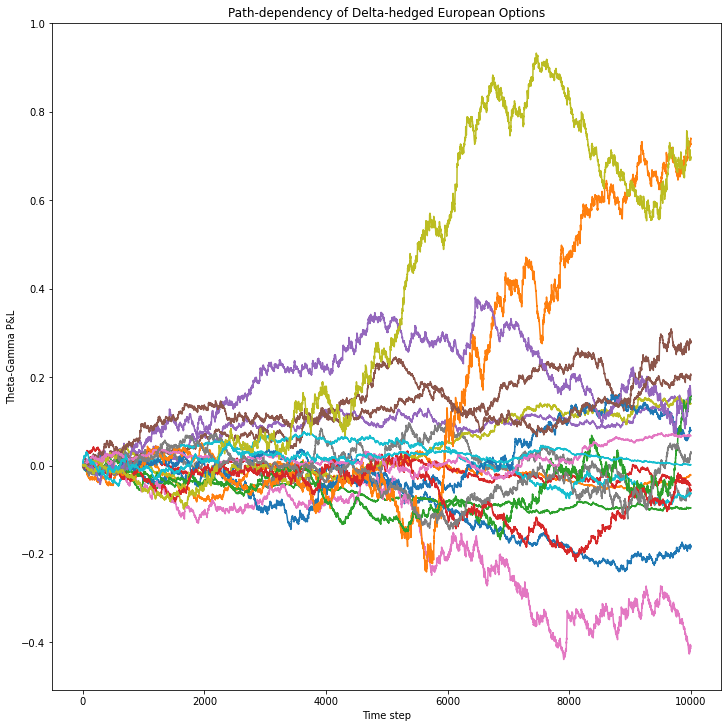

In [55]:
model = EquityDerivativesBS(100 , 1 , 100 , 0.4 , 0.04)
nb_paths = 20
nb_steps = 10000
spot_paths = create_spot_paths(model,nb_paths , nb_steps) 
gamma_theta_p_l = gamma_theta_pl(model, spot_paths , nb_paths, nb_steps)

plt.figure(figsize=(10, 10), layout='constrained')
plt.plot(gamma_theta_p_l)
plt.xlabel('Time step')
plt.ylabel('Theta-Gamma P&L')
plt.title("Path-dependency of Delta-hedged European Options")
plt.show()


In [186]:
## PARAMETERS ##
K = 100
r = 0.2
T = 1
sigma = 0.2
S0 = 100

spot_list = np.arange(10, 200, 0.1)
strike_list = np.linspace(20, 180, 9)

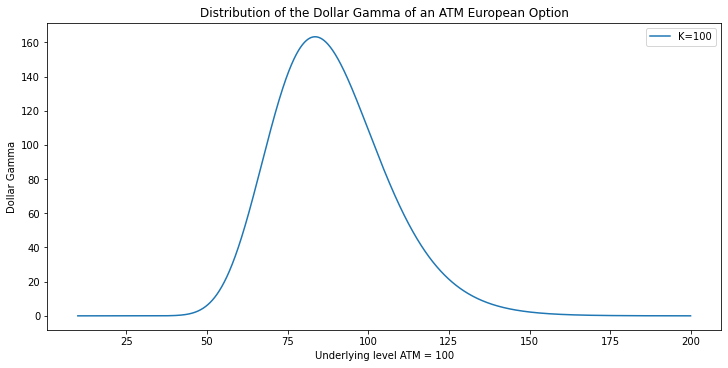

In [201]:
# Plot of the gamma distribution of an ATM European Option
plt.figure(figsize=(10, 5), layout='constrained')
plt.plot(spot_list, gamma_distribution(spot_list, 100), label='K=100')
plt.xlabel('Underlying level ATM = 100')
plt.ylabel('Dollar Gamma')
plt.title("Distribution of the Dollar Gamma of an ATM European Option")
plt.legend()
plt.show()

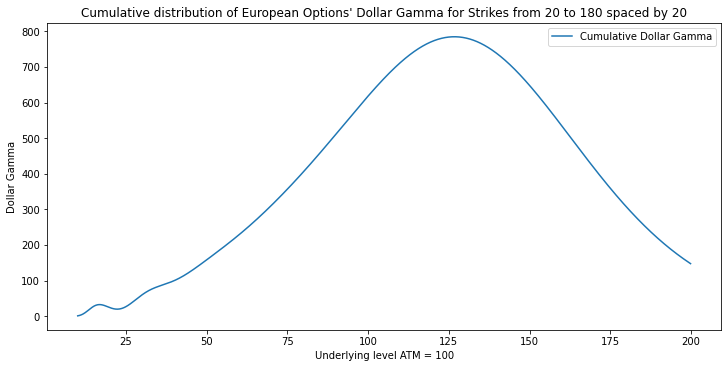

In [202]:
plt.figure(figsize=(10, 5), layout='constrained')
plt.plot(spot_list,
         cumulative_gamma_distribution(spot_list, strike_list),
         label='Cumulative Dollar Gamma')
plt.xlabel('Underlying level ATM = 100')
plt.ylabel('Dollar Gamma')
plt.legend()
plt.title(
    "Cumulative distribution of European Options' Dollar Gamma for Strikes from 20 to 180 spaced by 20"
)
plt.show()

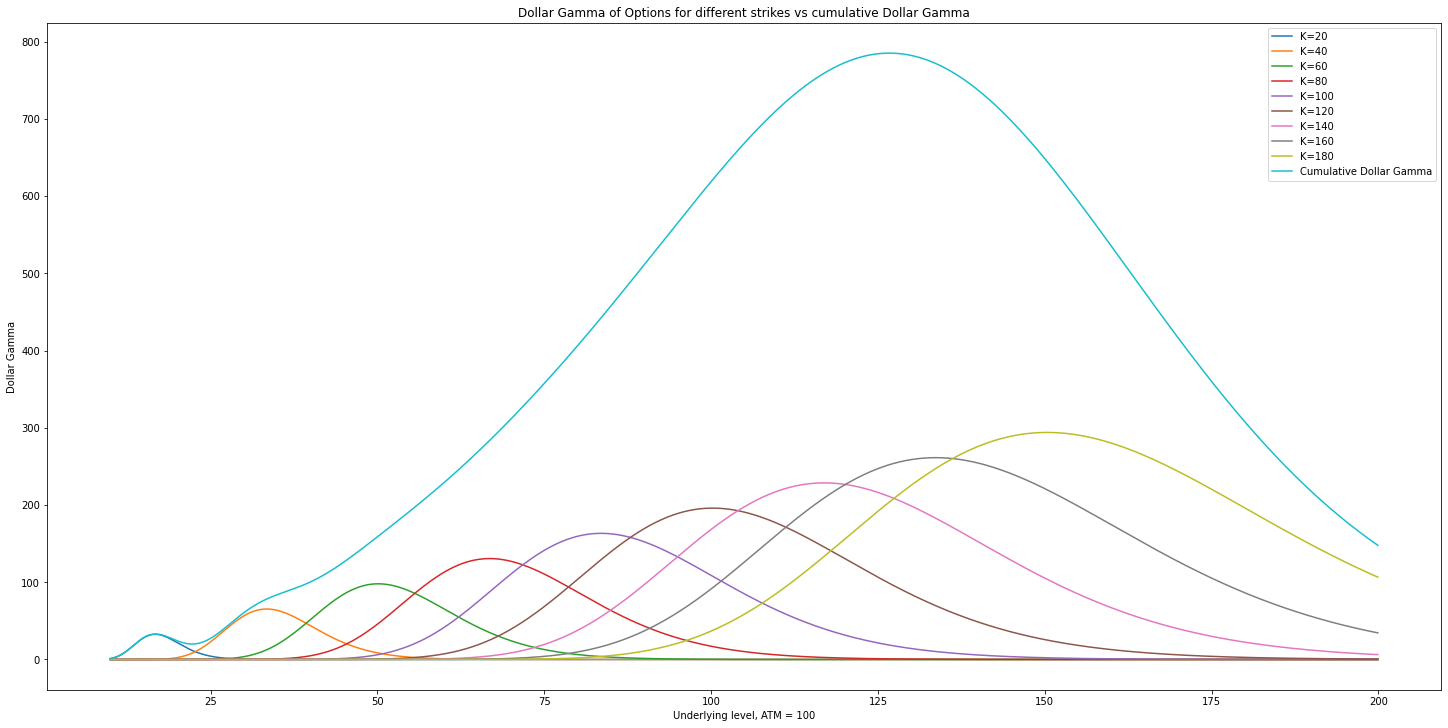

In [206]:
plt.figure(figsize=(20, 10), layout='constrained')
for strikes in strike_list:
    plt.plot(spot_list,
             gamma_distribution(spot_list, strikes),
             label='K=' + str(int(strikes)))
plt.plot(spot_list,
         cumulative_gamma_distribution(spot_list, strike_list),
         label='Cumulative Dollar Gamma')
plt.xlabel('Underlying level, ATM = 100')
plt.ylabel('Dollar Gamma')
plt.legend()
plt.title(
    'Dollar Gamma of Options for different strikes vs cumulative Dollar Gamma')
plt.show()

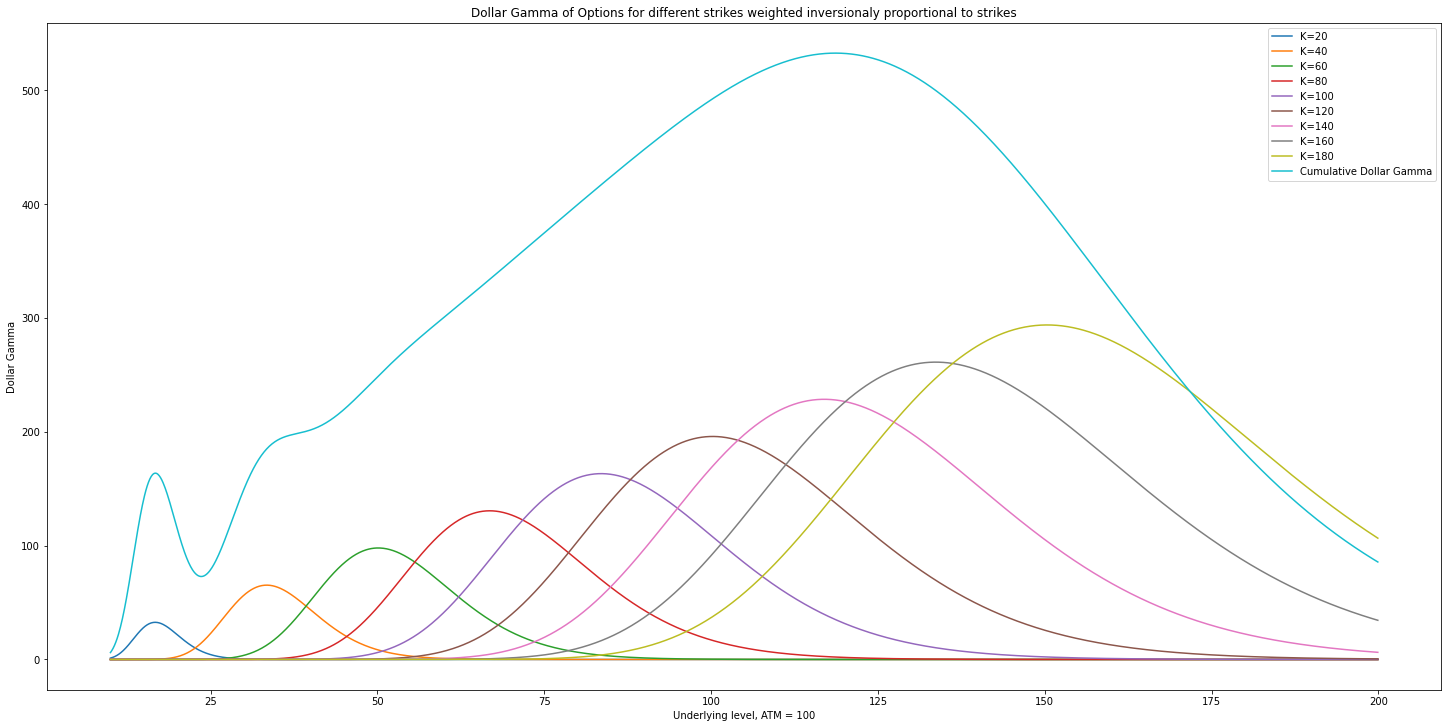

In [207]:
plt.figure(figsize=(20, 10), layout='constrained')
for strikes in strike_list:
    plt.plot(spot_list,
             gamma_distribution(spot_list, strikes),
             label='K=' + str(int(strikes)))
plt.plot(spot_list,
         cumulative_gamma_distribution_weight_K(spot_list, strike_list),
         label='Cumulative Dollar Gamma')

plt.xlabel('Underlying level, ATM = 100')
plt.ylabel('Dollar Gamma')
plt.title(
    'Dollar Gamma of Options for different strikes weighted inversionaly proportional to strikes'
)
plt.legend()
plt.show()

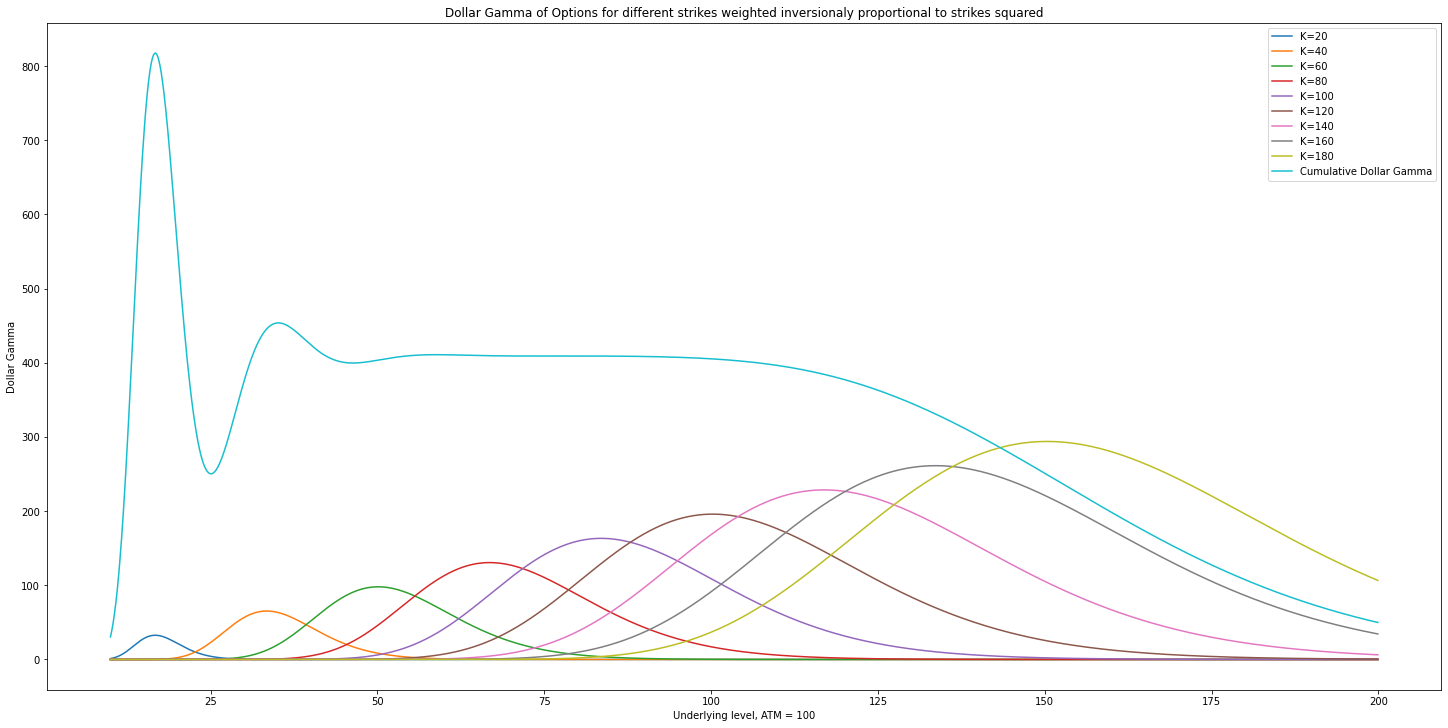

In [208]:
plt.figure(figsize=(20, 10), layout='constrained')
for strikes in strike_list:
    plt.plot(spot_list,
             gamma_distribution(spot_list, strikes),
             label='K=' + str(int(strikes)))
plt.plot(spot_list,
         cumulative_gamma_distribution_weight_K_squared(
             spot_list, strike_list),
         label='Cumulative Dollar Gamma')

plt.xlabel('Underlying level, ATM = 100')
plt.ylabel('Dollar Gamma')
plt.title(
    'Dollar Gamma of Options for different strikes weighted inversionaly proportional to strikes squared'
)
plt.legend()
plt.show()

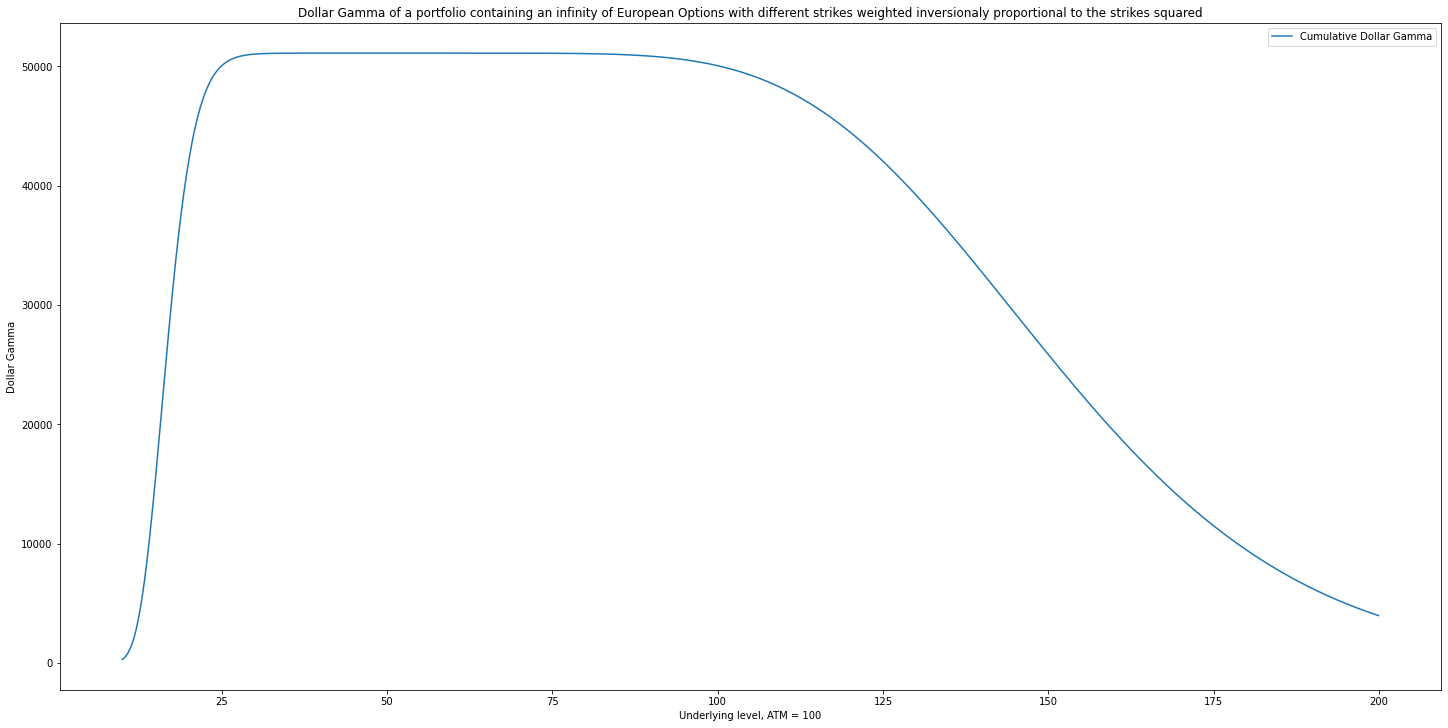

In [210]:
strike_list2 = np.linspace(20, 180, 1000)
plt.figure(figsize=(20, 10), layout='constrained')
plt.plot(spot_list,
         cumulative_gamma_distribution_weight_K_squared(
             spot_list, strike_list2),
         label='Cumulative Dollar Gamma')

plt.xlabel('Underlying level, ATM = 100')
plt.ylabel('Dollar Gamma')
plt.title(
    'Dollar Gamma of a portfolio containing an infinity of European Options with different strikes weighted inversionaly proportional to the strikes squared'
)
plt.legend()
plt.show()

In [262]:
# Variance swap pricing

ref_spot = 100
S0 = 100
r = 0.2
T = 1
sigma = 0.2

strike_list_put = np.linspace(ref_spot, 0, 10000)
strike_list_call = np.linspace(ref_spot, 400, 10000)

## Variance swap greeks ##
def variance_swap_gamma(t, T, S):
    return (2 / T) * (1 / S**2)


def variance_swap_vega(T, t, sigma):
    return (2 / T) * sigma * (T - t)


def variance_swap_theta(T, sigma):
    return -(1 / T) * (sigma**2)


def variance_swap_pay_off(realized_volatility, vol_strike, vega_notional):
    return (vega_notional / (2 * vol_strike)) * ((realized_volatility**2) -
                                                 (vol_strike**2))


def volatility_swap_pay_off(realized_volatility, vol_strike, vega_notional):
    return (vega_notional * (realized_volatility - vol_strike))

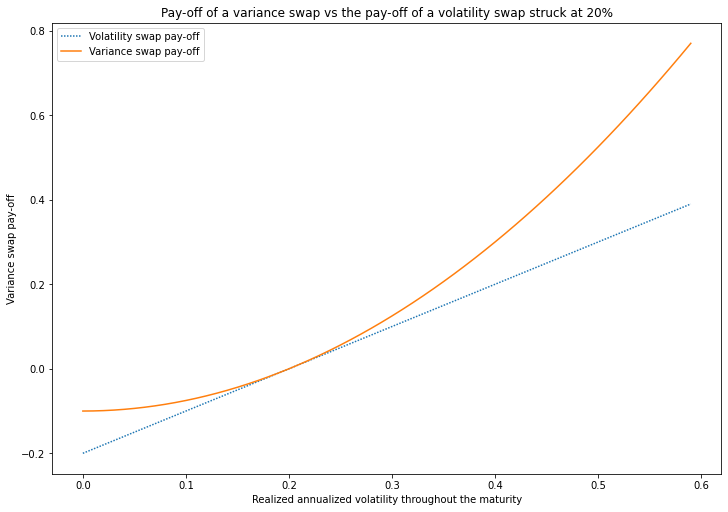

In [263]:
realized_volatilities = np.arange(0, 0.6, 0.01)
vol_strike = 0.2
vega_notional = 1

pay_off_variance = [
    variance_swap_pay_off(realized_volatility, vol_strike, vega_notional)
    for realized_volatility in realized_volatilities
]
pay_off_volatility = [
    volatility_swap_pay_off(realized_volatility, vol_strike, vega_notional)
    for realized_volatility in realized_volatilities
]

plt.figure(figsize=(10, 7), layout='constrained')
plt.plot(realized_volatilities,
         pay_off_volatility,
         label='Volatility swap pay-off',
         linestyle=(0, (1, 1)))
plt.plot(realized_volatilities,
         pay_off_variance,
         label='Variance swap pay-off')
plt.xlabel('Realized annualized volatility throughout the maturity')
plt.ylabel('Variance swap pay-off')
plt.title(
    'Pay-off of a variance swap vs the pay-off of a volatility swap struck at 20%'
)
plt.legend()
plt.show()



In [115]:
## Variance swaps MtM ## 
## We need to compute the forward variance strike at time t 
# PARAMETERS #

maturity = 1 
nb_steps = 1000
nb_paths = 2
dt = maturity / nb_steps

time_interval = np.arange(0,maturity,dt)
model = EquityDerivativesBS(100, 1, 100, 0.3, 0.04)
spot_paths = create_spot_paths(model, nb_paths , nb_steps)
print(realized_volatility(spot_paths))

def forward_starting_variance_strike(model , t ,maturity): 
    ## Returns K_t_T and K_0_T
    T = [t , maturity]
    variances_strike_t , variances_strike_T = model.variance_strike_discrete(T)
    forward_starting_strike_t = (maturity/(T-t))* variances_strike_T - (t/(T-t))*variances_strike_t
    return forward_starting_strike_t
    

    

#def variance _swap_mtm():
    ## Compute the MtM at time T. 
    
#def variance_swap_p_l(model , t , T): 
    


             0         1
0    -0.000783 -0.007197
1     0.001731  0.009652
2     0.004326  0.010930
3    -0.006694 -0.024619
4     0.006476  0.006367
...        ...       ...
996   0.004393 -0.020824
997  -0.023194  0.009986
998   0.006897 -0.007686
999   0.006462 -0.003940
1000       NaN       NaN

[1001 rows x 2 columns]
0    25.017425
1    24.667449
dtype: float64


In [ ]:
## Pricing under the Heston Stochastic volatility model ## 

class Heston():
    def __init__(self,r = 0.05,K=50,kappa=0.3,theta=0.04,xi = 0.1,sigma0=0.2):
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.sigma0=sigma0
        self.r = r
        self.K = K
        
    def variance(self,prev,dt):
        incr = self.kappa*(self.theta-prev)*dt+self.xi*np.sqrt(prev)*np.random.normal(0,np.sqrt(dt),len(prev))
        return prev+incr
    
    def generate_paths(self,n_paths,T=1,N=20,mu=0.04,S0=50,r_neutral = False):
        if r_neutral: mu = self.r
        logS = np.ones([1,n_paths])*np.log(S0)
        old_sigmas = np.ones(n_paths)*self.sigma0
        for i in range(N-1):
            previous_stock = logS[-1,:]
            sigmas_i = np.sqrt(self.variance(old_sigmas**2,T/N))
            old_sigmas =sigmas_i
            increments = (mu-0.5*sigmas_i**2)*T/N+sigmas_i*np.random.normal(0,np.sqrt(T)/np.sqrt(N),n_paths)
            logS = np.concatenate((logS,np.reshape(previous_stock+increments,[1,-1])),axis=0)
        S=np.exp(logS)
        return S
    
    def price_and_kvar(self,S,tau,n_paths=10000,N=200):
        paths = self.generate_paths(n_paths=n_paths,T=tau,N=N,S0=S, r_neutral=True)
        S_tau = paths[-1,:]
        payoffs = np.maximum(S_tau-self.K,0)
        price_ = np.exp(-self.r*tau)*np.mean(payoffs)
        tn = paths[:-1,:]
        tn1 = paths[1:,:]
        rv = 1/tau*np.mean(np.sum(np.log(tn1/tn)**2,axis=0))
        return price_,rv
    
    




In [ ]:
#Dispersion Trade P&L 



In [197]:
# Correlation Study # 
import datetime
import pandas_datareader.data as web

tickers = pd.read_csv('tickers.csv', sep=';')['ticker'].tolist()
source = 'yahoo'
time_index = pd.date_range(start='1/1/2010',end='1/1/2022', freq='3M')


time_index[0]

Timestamp('2010-01-31 00:00:00', freq='3M')